## Setup

In [1]:
# Install library ถ้ายังไม่มี
# !pip install grad-cam opencv-python

%load_ext autoreload
%autoreload 2

import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

# Setup Paths
sys.path.append('..')
from src.config import config
from src.models import get_model
from src.dataset import HAM10000Dataset
from src.transforms import get_transforms

print(f" Device: {config.DEVICE}")
print(f" Analyzing Model: {config.BASE_MODEL}")

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
 Device: mps
 Analyzing Model: efficientnet_b0


## Load Model & Weights

In [2]:
# 1. Initialize Model
device = config.DEVICE
model = get_model(device=device)

# 2. Load Weights
ckpt_path = config.CHECKPOINT_DIR / f'best_model_{config.BASE_MODEL}.pth'

if ckpt_path.exists():
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval() # สำคัญ! ต้องปรับเป็น eval mode
    print(f" Loaded weights from: {ckpt_path}")
else:
    print(f" Checkpoint not found: {ckpt_path}")
    print("   Please check config.py or run training first.")

 Building Model: EfficientNet-B0 (Baseline)
 Loaded weights from: /Users/mati/adv_skin_cancer/models/checkpoints/best_model_efficientnet_b0.pth


## Load Validation Data

In [3]:
# Load Validation Set
# ใช้ Transform แบบ 'val' (ไม่บิดเบือนภาพ) เพื่อความถูกต้อง
val_ds = HAM10000Dataset(
    config.PROCESSED_DATA_DIR / 'val.csv', 
    transform=get_transforms('val')
)

print(f" Validation Images: {len(val_ds)}")

 Validation Images: 1464


## Define Target Layer

In [4]:
# Select Target Layer based on Architecture
target_layers = []

if 'resnet' in config.BASE_MODEL:
    # สำหรับ ResNet50 เลเยอร์สุดท้ายคือ layer4 (block สุดท้าย)
    target_layers = [model.backbone.layer4[-1]]
    print(" Target Layer: ResNet Layer4[-1]")
    
elif 'efficientnet' in config.BASE_MODEL:
    # สำหรับ EfficientNet-B0 เลเยอร์สุดท้ายอยู่ใน features block สุดท้าย
    target_layers = [model.backbone.features[-1]]
    print(" Target Layer: EfficientNet Features[-1]")
    
else:
    print(" Unknown architecture! Printing model structure to help you find the layer...")
    # print(model)

 Target Layer: EfficientNet Features[-1]


## Visualization Function

In [5]:
def visualize_gradcam(index, target_class_idx=None):
    """
    Args:
        index: ลำดับรูปใน validation set (0 ถึง len(val_ds)-1)
        target_class_idx: (Optional) ถ้าอยากบังคับให้ดูว่าทำไมโมเดลถึงทายเป็นโรคนั้น
                          ถ้าไม่ใส่ จะใช้ class ที่โมเดลทายออกมาเอง (Max Prediction)
    """
    # 1. Get Image & Label
    img_tensor, label_idx = val_ds[index]
    image_path = val_ds.df.iloc[index]['image_path']
    true_label = config.IDX_TO_CLASS[label_idx.item()]
    
    # 2. Prepare Input
    input_tensor = img_tensor.unsqueeze(0).to(device)
    
    # 3. Initialize GradCAM
    cam = GradCAM(model=model, target_layers=target_layers)
    
    # 4. Define Targets
    if target_class_idx is None:
        targets = None # Auto: ใช้คลาสที่โมเดลมั่นใจที่สุด
    else:
        targets = [ClassifierOutputTarget(target_class_idx)]
        
    # 5. Generate CAM
    # You can pass aug_smooth=True and eigen_smooth=True to have smoother CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    # 6. Overlay on Original Image
    # ต้องโหลดรูปต้นฉบับมาใหม่เพื่อความสวยงาม (ไม่เอาแบบ Normalize แล้ว)
    rgb_img = Image.open(image_path).resize((224, 224))
    rgb_img = np.float32(rgb_img) / 255
    
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    # 7. Prediction for Title
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        pred_idx = output.argmax(dim=1).item()
        pred_label = config.IDX_TO_CLASS[pred_idx]
        conf = probs[0][pred_idx].item()
        
    # 8. Plot
    plt.figure(figsize=(10, 5))
    
    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title(f"Original: {true_label}")
    plt.axis('off')
    
    # Grad-CAM
    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"Pred: {pred_label} ({conf:.2%})\nTrue: {true_label}", color=color)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print(" Visualization function ready!")

 Visualization function ready!


## Visualize Melanoma Cases (Successes)

 Visualizing Melanoma (MEL) cases...


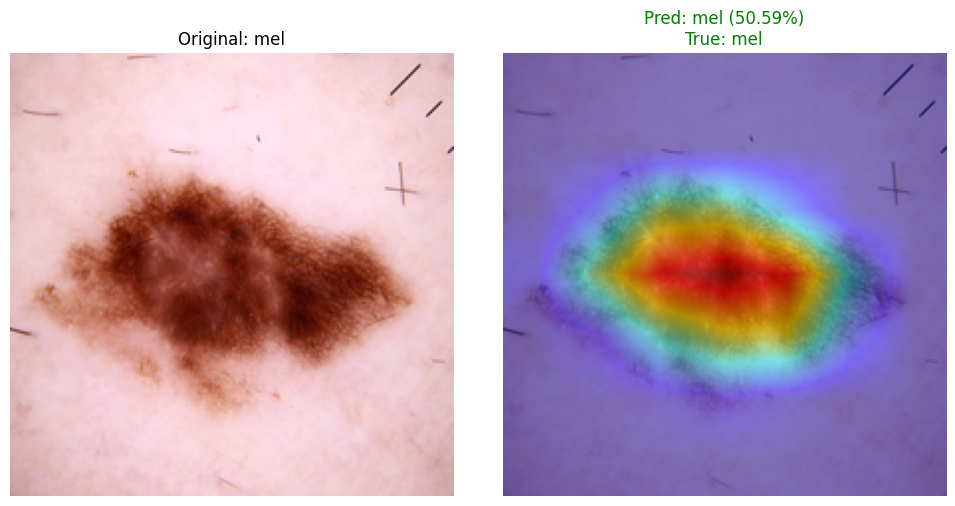

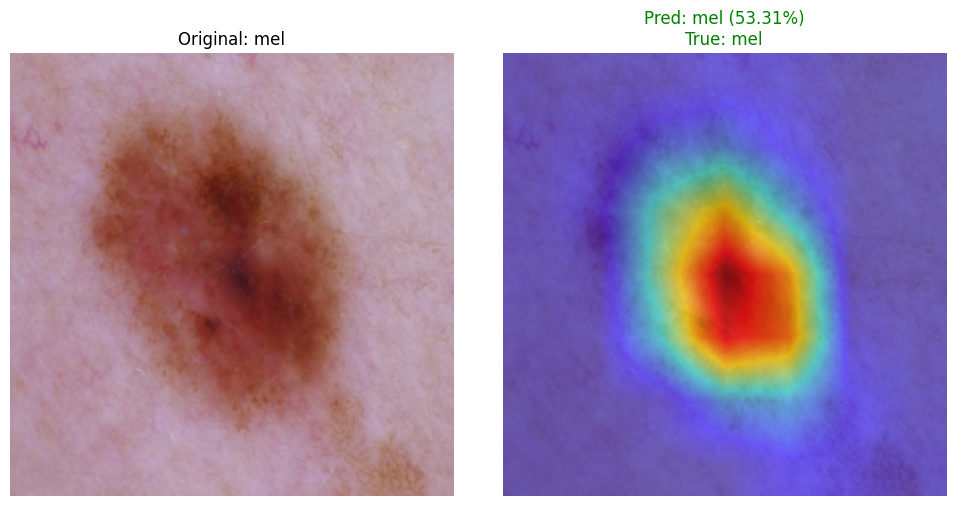

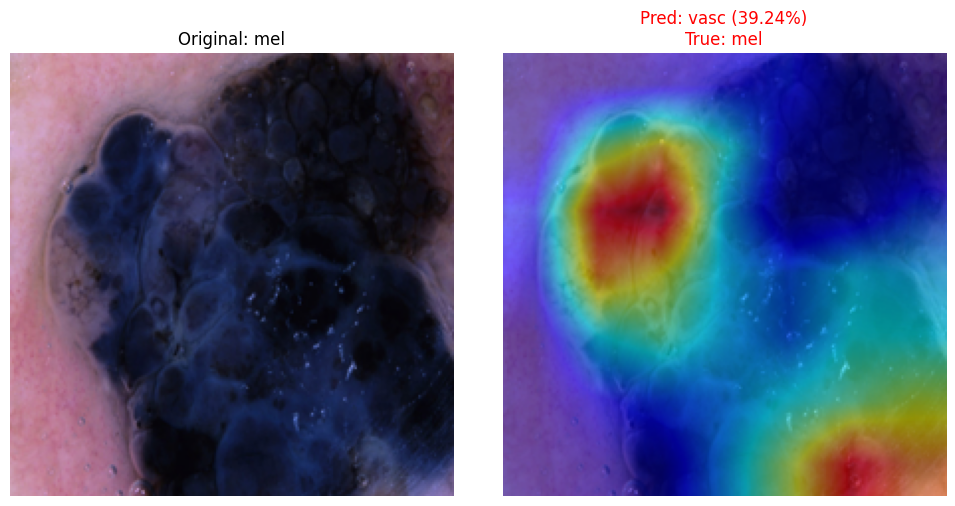

In [6]:
print(" Visualizing Melanoma (MEL) cases...")

# หา index ของรูปที่เป็น Mel
mel_indices = val_ds.df[val_ds.df['dx'] == 'mel'].index.tolist()

# สุ่มดูสัก 3-5 รูป
np.random.seed(config.SEED) # Lock seed เพื่อให้ผลเหมือนเดิมเวลา capture ลงเล่ม
selected_indices = np.random.choice(mel_indices, 3, replace=False)

for idx in selected_indices:
    visualize_gradcam(idx)

## Error Analysis (Failures)

 Visualizing Error Cases (False Negatives / False Positives)...
Found 3 error cases. Showing visualization:


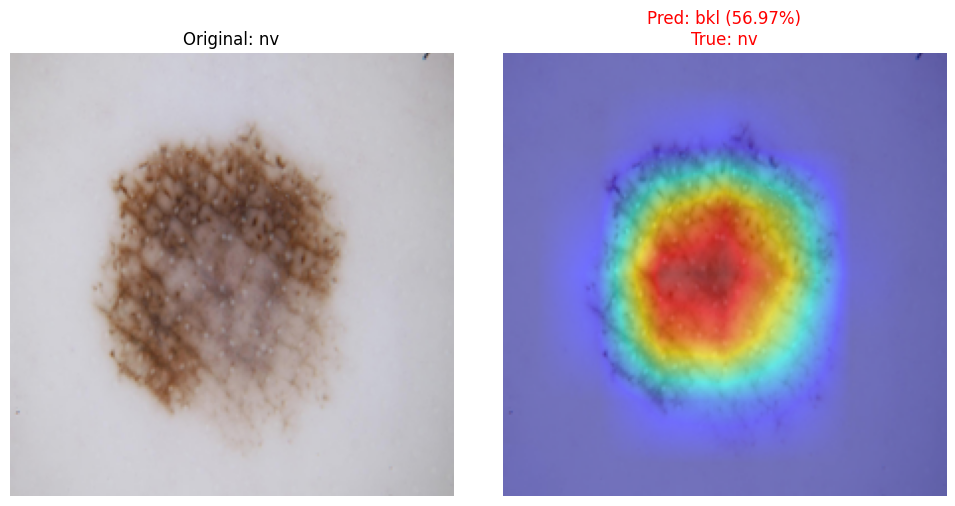

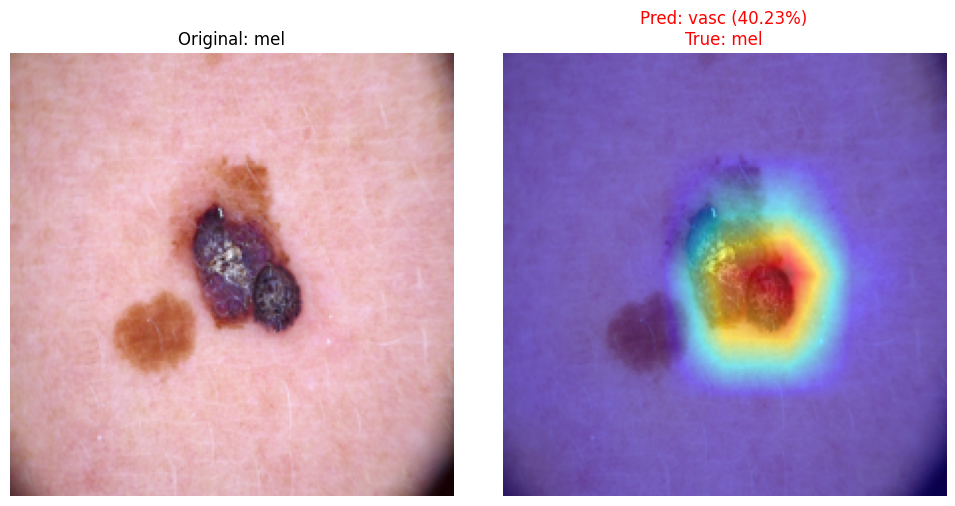

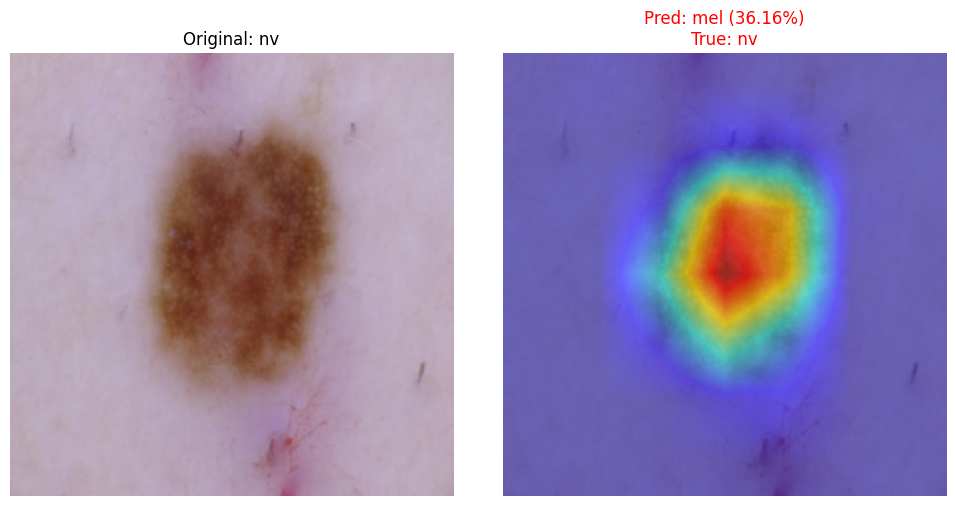

In [8]:
print(" Visualizing Error Cases (False Negatives / False Positives)...")

# 1. วนลูปหาเคสที่ผิด (สุ่มหาเอาก็ได้ครับ หรือจะรัน inference loop เล็กๆ)
error_indices = []
max_errors = 3

# ลองสุ่มเช็คสัก 100 รูป
check_indices = np.random.choice(len(val_ds), 100, replace=False)

for idx in check_indices:
    img_tensor, label_idx = val_ds[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = output.argmax(dim=1).item()
        
    if pred_idx != label_idx.item():
        error_indices.append(idx)
        if len(error_indices) >= max_errors:
            break

# 2. แสดงผล
if len(error_indices) > 0:
    print(f"Found {len(error_indices)} error cases. Showing visualization:")
    for idx in error_indices:
        visualize_gradcam(idx)
else:
    print(" Amazing! In the random sample, no errors were found.")